# Neural Network mapping to learn MODIS LST from ERA features


# 1. Load all data

We have a bunch of hourly files. Lets load them up as a single pandas dataframe

In [34]:
import glob
import pandas as pd 
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
df = pd.read_pickle(root+'ML_data.pkl') #Generated by code cell below

In [9]:
# import pandas as pd
#all_files = sorted(glob.glob(root+'outputs_multi/*.pkl'))
# dfs = []
# for f in all_files:
#     df = pd.read_pickle(f)
#     dfs.append(df)
    
# df = pd.concat(dfs).reset_index()
# #and save to disk
# df.to_pickle(root+'ML_data.pkl')

In [35]:
df

level_0  index  index_ERA  values             sp          msl  \
0               0     44         44      44  101015.835938  101269.9375   
1               1     45         45      45  100863.835938  101323.9375   
2               2     46         46      46  100629.835938  101396.4375   
3               3     47         47      47  100637.835938  101472.6875   
4               4     48         48      48  100684.835938  101527.1875   
...           ...    ...        ...     ...            ...          ...   
52887316     3469  22585      22585   22585   80073.320312   98447.8125   
52887317     3470  22586      22586   22586   83346.320312   98477.0625   
52887318     3471  22587      22587   22587   86542.320312   98506.5625   
52887319     3472  22588      22588   22588   91371.320312   98468.0625   
52887320     3473  22590      22590   22590   97386.320312   98364.5625   

                u10        v10         t2m  latitude_ERA  ...       lsm  \
0        -13.898163  -1.774475  251.593750     69.836018  ...  0.587258   
1        -12.919647  -0.952209  251.330078     69.836018  ...  0.975585   
2        -12.093475  -0.199280  251.474609     69.836018  ...  0.990949   
3        -10.584686   0.352478  251.509766     69.836018  ...  0.997583   
4         -9.656952   0.549744  251.644531     69.836018  ...  1.000000   
...             ...        ...         ...           ...  ...       ...   
52887316  10.642303  12.688187  242.925247    -69.836018  ...  1.000000   
52887317   9.440155  12.255569  244.669388    -69.836018  ...  1.000000   
52887318   8.029022  10.688187  246.450638    -69.836018  ...  1.000000   
52887319   6.629608   6.075882  249.366653    -69.836018  ...  1.000000   
52887320   5.197968   2.157913  249.311966    -69.836018  ...  1.000000   

               fal index_MODIS latitude_MODIS  longitude_MODIS band  \
0         0.783996      209767          69.85      -162.750000    1   
1         0.777801      209789          69.85      -162.016667    1   
2         0.783813      209812          69.85      -161.250000    1   
3         0.788315      209834          69.85      -160.516667    1   
4         0.786941      209857          69.85      -159.750000    1   
...            ...         ...            ...              ...  ...   
52887316  0.850003        1957         -69.85        65.250000    1   
52887317  0.850003        1979         -69.85        65.983333    1   
52887318  0.850003        2002         -69.85        66.750000    1   
52887319  0.850003        2024         -69.85        67.483333    1   
52887320  0.850003        2069         -69.85        68.983333    1   

          spatial_ref   MODIS_LST  distance  MODIS_idx  
0                   0  254.219345  1.554724     209767  
1                   0  255.070007  1.680773     209789  
2                   0  253.717499  1.554724     209812  
3                   0  249.159653  1.680773     209834  
4                   0  248.395142  1.554724     209857  
...               ...         ...       ...        ...  
52887316            0  242.395004  1.554724       1957  
52887317            0  243.657501  1.680773       1979  
52887318            0  245.746246  1.554724       2002  
52887319            0  247.867493  1.680773       2024  
52887320            0  246.393753  1.680773       2069  

[52887321 rows x 42 columns]

# 2. Train the model

In [36]:
import tensorflow as tf



def train_test_split(df,filter_condition,train_condition, test_condition,features,targets):
    
    #Filter dataset
    df_filtered = df.query(filter_condition)
    
    
    #Select train/test data
    training_data = df_filtered.query(train_condition)
    test_data     = df_filtered.query(test_condition)
    
    
    #Separate into features/targets

    x_train = training_data[features]
    y_train = training_data[targets]

    x_test = test_data[features]
    y_test = test_data[targets]
    
    
    return x_train,y_train,x_test,y_test
    
    




def train_NN(x_train,y_train):


    #Check GPU available
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

    #Create a normaliser layer
    print ('Creating a normalization layer')
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(x_train)



    #Create a basic NN model
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(int(len(features)/2), activation='relu',input_shape=(len(features),),name='layer1'),
        tf.keras.layers.Dense(1, name='output')
  ])

    #Compile it
    print ('Compiling model')
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    

    
    #Train it
    print('Training model')
    history = model.fit(x_train, y_train, epochs=100, batch_size=128) 
    
    
    return history, model





In [39]:
#Process input data
filter_condition = 'distance <= 1.0'
train_condition = 'time < "2019-01-01 00:00:00"'
test_condition = 'time >= "2020-01-01 00:00:00"'
features = ['sp', 'msl', 'u10', 'v10','t2m',
            'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
            'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
            'd2m', 'lsm', 'fal'] 

targets = ['MODIS_LST']


x_train,y_train,x_test,y_test = train_test_split(df,filter_condition,train_condition, test_condition,features,targets)


In [15]:












#train_NN(df_filtered,train_condition,test_condition) #Already trained model, dont need to train it again
#model.save('model_epochs100_batch128')

# 3. Test and evaluate the model

In [5]:
#Load the trained model
model = tf.keras.models.load_model('model_epochs100_batch128')

2022-03-08 15:55:25.268260: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-08 15:55:25.719268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


# 3.1 Evaluate entire test set

In [28]:
#Predictions


#24 hour snapshot
test_data = df_filtered.query('time >= "2020-01-01 00:00:00"')

features = ['sp', 'msl', 'u10', 'v10','t2m',
            'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
            'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
            'd2m', 'lsm', 'fal'] 
targets = ['MODIS_LST']


#Make some predictions, just for that 24 hours
predictions = model.predict(test_data[features])




In [29]:
#results = model.evaluate(x_test, y_test, batch_size=128)
predictions

array([[246.86885],
       [245.98167],
       [247.06136],
       ...,
       [241.7978 ],
       [241.77829],
       [244.85487]], dtype=float32)

In [30]:
#Create a simple results df

df_results = test_data[['longitude_ERA', 'latitude_ERA', 'MODIS_LST']].copy()
df_results['predict'] = predictions
df_results['delta'] = abs(df_results.MODIS_LST - df_results.predict)

In [32]:
df_results.delta.mean()

3.5270348

In [33]:
df_results.delta.median()

2.715332

# 3.2 Evaluate 24 hour snapshot

In [13]:
#Predictions


#24 hour snapshot
test_data_24 = df_filtered.query(' "2020-01-06 00:00:00" <= time < "2020-01-07 00:00:00"')

features = ['sp', 'msl', 'u10', 'v10','t2m',
            'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
            'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
            'd2m', 'lsm', 'fal'] 
targets = ['MODIS_LST']


#Make some predictions, just for that 24 hours
predictions = model.predict(test_data_24[features])



2022-03-08 15:56:14.505896: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [24]:
#Create a simple results df

df_results = test_data_24[['longitude_ERA', 'latitude_ERA', 'MODIS_LST']].copy()
df_results['predict'] = predictions
df_results['delta'] = abs(df_results.MODIS_LST - df_results.predict)

In [25]:
df_results

longitude_ERA  latitude_ERA   MODIS_LST     predict     delta
48366892        -162.75     69.554988  238.599655  239.936905  1.337250
48366893        -162.00     69.554988  237.633743  240.577164  2.943420
48366894        -161.25     69.554988  239.007065  241.229202  2.222137
48366895        -160.50     69.554988  235.139999  237.999039  2.859039
48366896        -159.75     69.554988  231.563751  235.201797  3.638046
...                 ...           ...         ...         ...       ...
48427437          65.25    -69.554988  264.316254  259.466278  4.849976
48427438          66.00    -69.554988  265.380005  261.079559  4.300446
48427439          66.75    -69.554988  266.256256  261.375153  4.881104
48427440          67.50    -69.554988  268.473755  262.178864  6.294891
48427441          68.25    -69.554988  269.686249  263.826202  5.860046

[13564 rows x 5 columns]

In [26]:
df_results.delta.mean()

3.6150832

In [27]:
df_results.delta.median()

2.770752

In [22]:
df_results_grouped = df_results.groupby('latitude_ERA')

In [23]:
df_results_grouped

In [17]:
import geopandas as gpd
def plot_map(df,x,y,q): #slow plotting function
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    

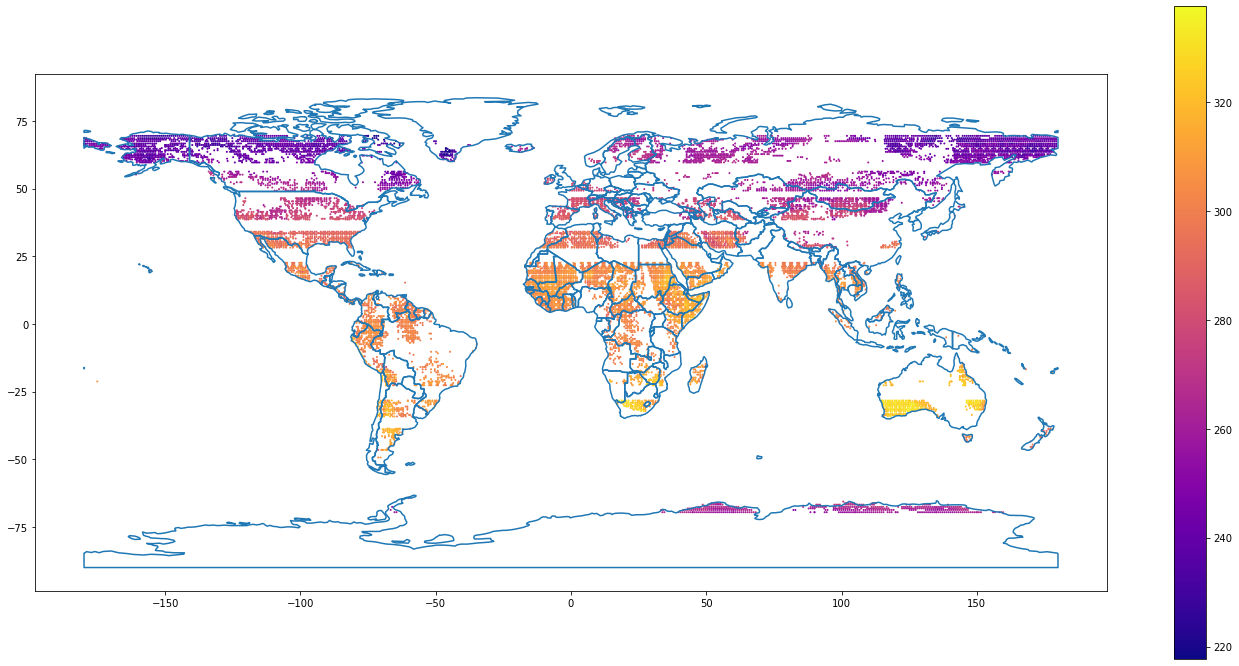

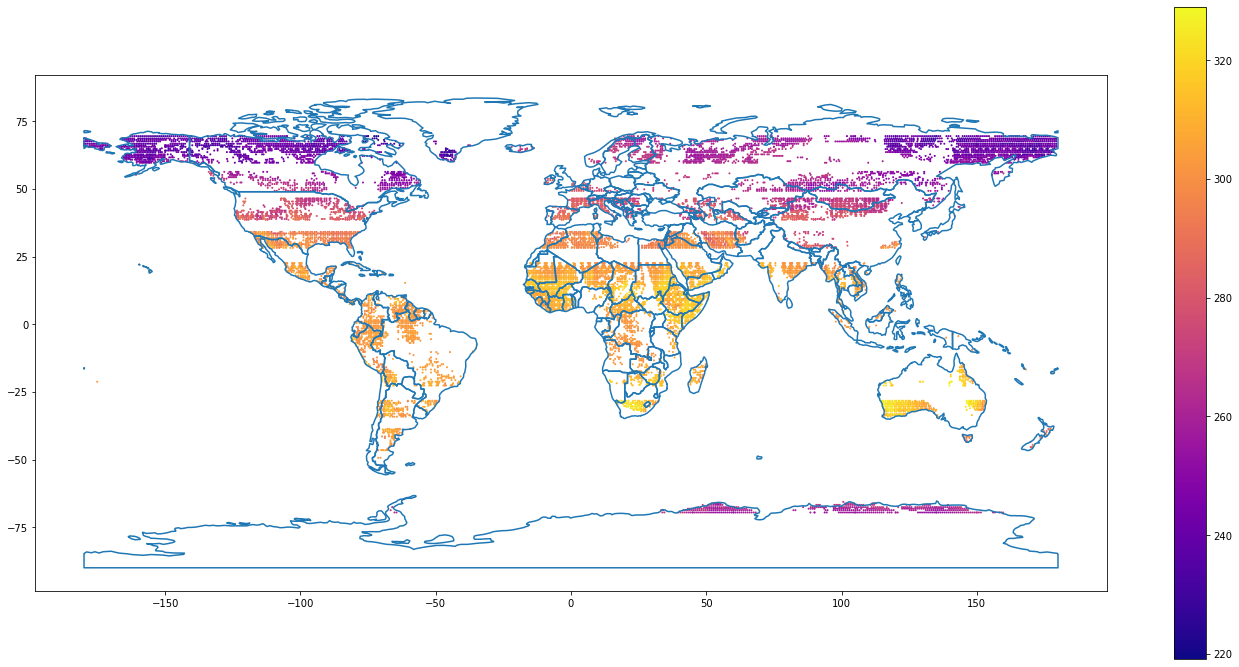

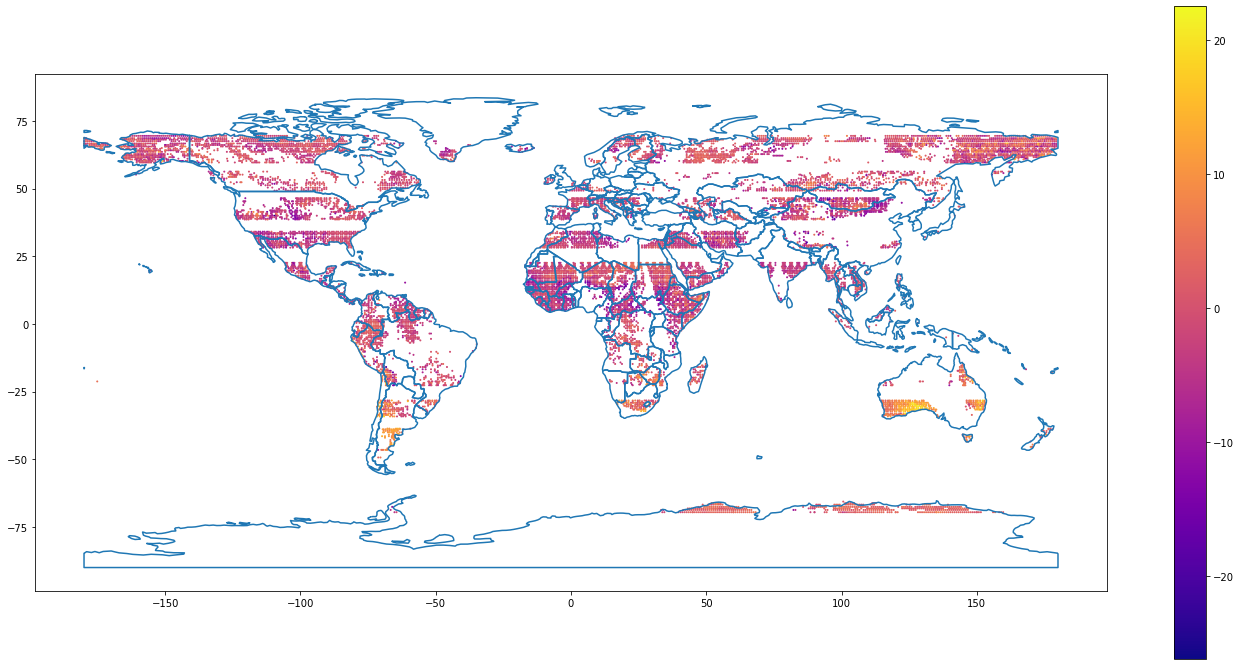

In [18]:
plot_map(df_results,'longitude_ERA', 'latitude_ERA', 'MODIS_LST')
plot_map(df_results,'longitude_ERA', 'latitude_ERA', 'predict')
plot_map(df_results,'longitude_ERA', 'latitude_ERA', 'delta')

In [2]:
2+6

8


Now lets separate this data into:
* A training set of 1 year: 2018
* A test set of 1 year: 2020 (not all data is there)

For now leave 2019 as buffer / validation

In [9]:
training_data = df_filtered.query('time < "2019-01-01 00:00:00"')
test_data = df_filtered.query('time >= "2020-01-01 00:00:00"')

And then separate these dfs into features/targets:

In [10]:
training_data.columns

Index(['level_0', 'index', 'index_ERA', 'values', 'sp', 'msl', 'u10', 'v10',
       't2m', 'latitude_ERA', 'longitude_ERA', 'number', 'time', 'step',
       'surface', 'valid_time', 'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
       'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
       'd2m', 'lsm', 'fal', 'index_MODIS', 'latitude_MODIS', 'longitude_MODIS',
       'band', 'spatial_ref', 'MODIS_LST', 'distance', 'MODIS_idx'],
      dtype='object')

In [11]:
import tensorflow as tf

features = ['sp', 'msl', 'u10', 'v10','t2m',
            'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
            'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
            'd2m', 'lsm', 'fal'] 
targets = ['MODIS_LST']

x_train = training_data[features]
y_train = training_data[targets]

x_test = test_data[features]
y_test = test_data[targets]

#Can also use tf.convert_to_tensor().  See https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
x_train

sp          msl        u10       v10         t2m  \
12        100934.835938  101071.6875 -13.703827 -2.729553  251.882812   
13        100402.835938  101149.9375 -13.153046 -0.848694  251.597656   
14         99756.835938  101260.6875 -12.200897  0.535095  251.232422   
15         99372.835938  101384.4375 -10.169647  1.063416  250.484375   
16         99563.835938  101462.4375  -8.391327  1.050720  250.712891   
...                 ...          ...        ...       ...         ...   
23978245   81249.523438   99511.5625  -1.604355  3.538422  264.200714   
23978246   83915.523438   99550.0625  -0.176620  4.582367  264.991730   
23978247   85775.523438   99560.3125   1.380020  4.387054  265.583527   
23978248   88248.523438   99547.0625   2.069473  3.418304  266.868683   
23978249   93081.523438   99516.8125   1.511856  2.231781  269.431183   

             aluvp     aluvd     alnip     alnid        cl  ...      sdfor  \
12        0.046606  0.050012  0.177746  0.194669  0.080565  ...   4.544800   
13        0.048178  0.050745  0.191708  0.206052  0.044154  ...   9.603577   
14        0.049963  0.051294  0.226574  0.236631  0.003064  ...  19.103333   
15        0.049932  0.051492  0.230618  0.241834  0.000772  ...  21.474121   
16        0.050268  0.053186  0.236126  0.249372  0.000000  ...  24.881104   
...            ...       ...       ...       ...       ...  ...        ...   
23978245  0.149996  0.149998  0.149996  0.150007  0.000000  ...  22.450745   
23978246  0.149996  0.149998  0.149996  0.150007  0.000000  ...   6.978821   
23978247  0.149996  0.149998  0.149996  0.150007  0.000000  ...  10.043457   
23978248  0.149996  0.149998  0.149996  0.150007  0.000000  ...  16.965027   
23978249  0.149996  0.149998  0.149996  0.150007  0.000000  ...  47.995178   

                     z         sd       sdor      isor      anor      slor  \
12           97.570068   0.076196  15.262939  0.373392 -1.094476  0.001563   
13          535.452881   0.079093  23.758423  0.308915 -1.350477  0.002586   
14         1080.245850   0.082648  19.302124  0.752162  1.560140  0.003029   
15         1444.406006   0.091681  27.854614  0.752599  1.244012  0.004373   
16         1362.550537   0.092123  19.697632  0.654927 -0.099509  0.004450   
...                ...        ...        ...       ...       ...       ...   
23978245  15612.574219  10.000000  29.998413  0.420011 -0.036301  0.006191   
23978246  13154.601562  10.000000  14.483154  0.571691 -1.117376  0.001981   
23978247  11467.980469  10.000000  19.530640  0.371203 -0.483105  0.003005   
23978248   9283.320312  10.000000  45.188110  0.527285 -0.515352  0.005550   
23978249   5174.242188  10.000000  77.418091  0.392391 -0.060128  0.014614   

                 d2m       lsm       fal  
12        248.263565  0.919435  0.773712  
13        248.224503  0.955846  0.789795  
14        248.054581  0.996936  0.793457  
15        248.042862  0.999228  0.795685  
16        248.394424  1.000000  0.793899  
...              ...       ...       ...  
23978245  258.072266  1.000000  0.849999  
23978246  258.853516  1.000000  0.849999  
23978247  259.558594  1.000000  0.849999  
23978248  260.363281  1.000000  0.849999  
23978249  262.480469  1.000000  0.849999  

[5207055 rows x 23 columns]

## 2. Construct a simple model

Lets construct a simple sequential NN in tensorflow.

In [13]:
#Create a normaliser layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(x_train)

2022-03-07 15:57:28.444562: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 15:57:28.951347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0


In [14]:
len(features)

23

In [15]:
#Model
def get_basic_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(int(len(features)/2), activation='relu',input_shape=(len(features),),name='layer1'),
        tf.keras.layers.Dense(int(len(features)/2), activation='relu',name='layer2'),
        #tf.keras.layers.Dense(3, activation='relu',name='layer2'),
        tf.keras.layers.Dense(1, name='output')
  ])

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1.0e-4),
    #               loss='mse',
    #               metrics=['accuracy'])
    
    
    
    return model

In [16]:
%%time
model = get_basic_model()
#model.summary()
history = model.fit(x_train, y_train, epochs=100, batch_size=128) 

Epoch 1/100
  120/40681 [..............................] - ETA: 52s - loss: 87242.4609 - accuracy: 0.0000e+00   

2022-03-07 15:59:19.378717: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40681/40681 [==============================] - 54s 1ms/step - loss: 1092.5039 - accuracy: 0.0000e+00
Epoch 2/100
40681/40681 [==============================] - 54s 1ms/step - loss: 24.6447 - accuracy: 0.0000e+00
Epoch 3/100
40681/40681 [==============================] - 55s 1ms/step - loss: 24.3386 - accuracy: 0.0000e+00
Epoch 4/100
40681/40681 [==============================] - 54s 1ms/step - loss: 24.1537 - accuracy: 0.0000e+00
Epoch 5/100
40681/40681 [==============================] - 54s 1ms/step - loss: 24.0374 - accuracy: 0.0000e+00
Epoch 6/100
40681/40681 [==============================] - 54s 1ms/step - loss: 23.8709 - accuracy: 0.0000e+00
Epoch 7/100
40681/40681 [==============================] - 53s 1ms/step - loss: 23.6812 - accuracy: 0.0000e+00
Epoch 8/100
40681/40681 [==============================] - 53s 1ms/step - loss: 23.2992 - accuracy: 0.0000e+00
Epoch 9/100
40681/40681 [==============================] - 56s 1ms/step - loss: 23.0651 - accuracy: 0.0000e+00
Epoch 10/10

In [2]:
model.save('model_epochs100_batch128')

NameError: name 'model' is not defined

## 3. Use the trained model to make some predictions

In [ ]:
model = tf.keras.models.load_model('model_epochs100_batch128')
predictions = model.predict(x_test)

In [ ]:
predictions

In [28]:
predictions

array([[246.86885],
       [245.98167],
       [247.06136],
       ...,
       [241.7978 ],
       [241.77829],
       [244.85487]], dtype=float32)

In [25]:
# Evaluate the model on the test data using `evaluate`

evals = model.evaluate(x_test, y_test, batch_size=10000)
print("test loss, test acc:", evals)

331/331 [==============================] - 0s 973us/step - loss: 44.3445 - accuracy: 0.0000e+00
test loss, test acc: [44.34449768066406, 0.0]


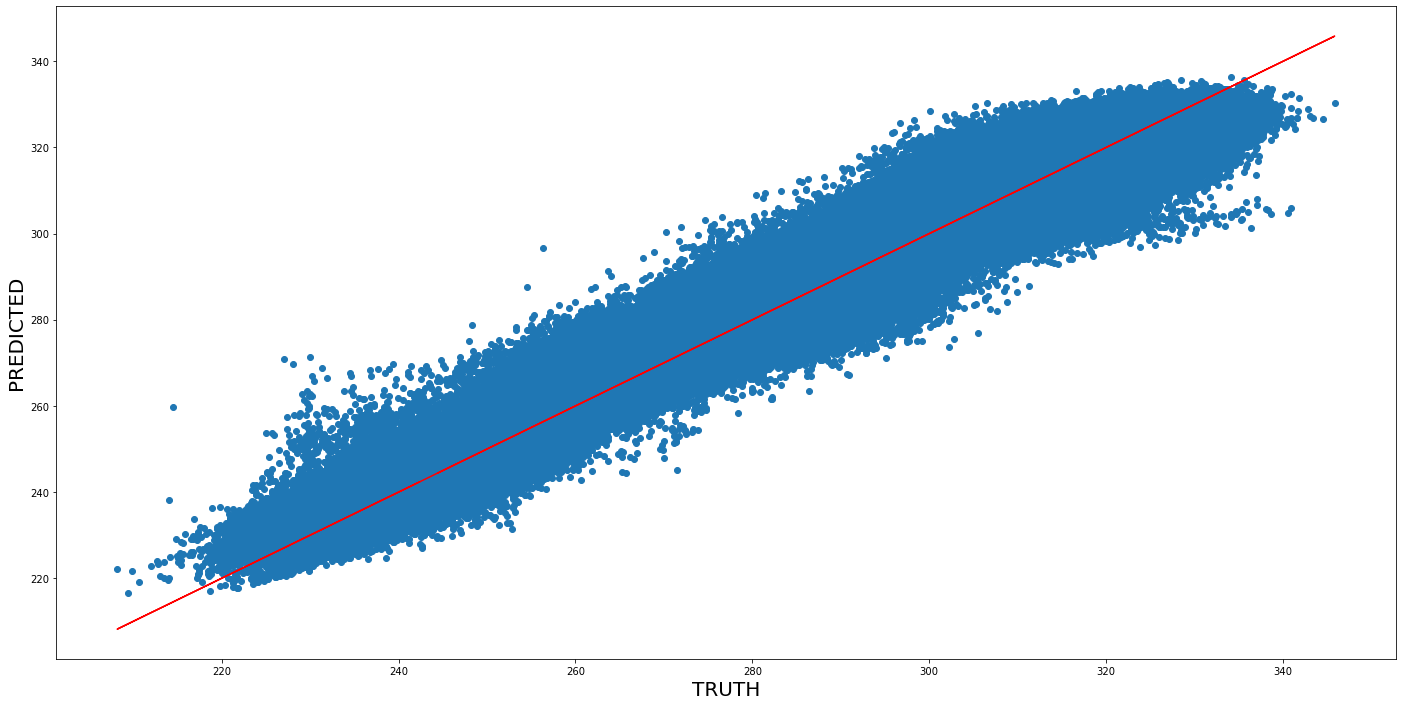

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))



plt.scatter(y_test,predictions)

plt.plot(y_test,y_test,c='r')

plt.xlabel('TRUTH',fontsize=20)
plt.ylabel('PREDICTED',fontsize=20)
plt.show()

#    plt.plot(y_test, y_test,c='r')

# 4. Pipeline

Lets put all those above steps into a single function that can be called:

In [38]:

def train_NN(df,train_condition,test_condition):

    print ('Getting data organized')
    #Select train/test data
    training_data = df.query(train_condition)
    test_data = df.query(test_condition)

    #Split train/test into features/targets
    features = ['sp', 'msl', 'u10', 'v10','t2m',
                'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
                'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
                'd2m', 'lsm', 'fal'] 
    targets = ['MODIS_LST']

    x_train = training_data[features]
    y_train = training_data[targets]

    x_test = test_data[features]
    y_test = test_data[targets]

    #Check GPU available
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

    #Create a normaliser layer
    print ('Creating a normalization layer')
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(x_train)



    #Create a basic NN model
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(int(len(features)/2), activation='relu',input_shape=(len(features),),name='layer1'),
        tf.keras.layers.Dense(1, name='output')
  ])

    #Compile it
    print ('Compiling model')
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    

    
    #Train it
    print('Training model')
    history = model.fit(x_train, y_train, epochs=100, batch_size=128) 
    
    
    return history,model,x_train,y_train,x_test,y_test




In [39]:

train_condition = '"2018-01-01 00:00:00" <= time < "2018-02-01 00:00:00"'
test_condition = '"2020-01-01 00:00:00" <= time < "2020-02-01 00:00:00"'

train_NN(df_filtered,train_condition,test_condition)

Getting data organized
Num GPUs Available:  1
Creating a normalization layer
Compiling model
Training model
Epoch 1/100
3148/3148 [==============================] - 4s 1ms/step - loss: 47051.1133 - accuracy: 0.0000e+00
Epoch 2/100
3148/3148 [==============================] - 4s 1ms/step - loss: 7602.1060 - accuracy: 0.0000e+00
Epoch 3/100
3148/3148 [==============================] - 4s 1ms/step - loss: 1061.3925 - accuracy: 0.0000e+00
Epoch 4/100
3148/3148 [==============================] - 4s 1ms/step - loss: 355.3078 - accuracy: 0.0000e+00
Epoch 5/100
3148/3148 [==============================] - 4s 1ms/step - loss: 144.4558 - accuracy: 0.0000e+00
Epoch 6/100
3148/3148 [==============================] - 4s 1ms/step - loss: 75.3601 - accuracy: 0.0000e+00
Epoch 7/100
3148/3148 [==============================] - 4s 1ms/step - loss: 50.5137 - accuracy: 0.0000e+00
Epoch 8/100
3148/3148 [==============================] - 4s 1ms/step - loss: 38.8184 - accuracy: 0.0000e+00
Epoch 9/100
3148/31

(<keras.callbacks.History at 0x7f12d0576110>,
                     sp          msl        u10       v10         t2m  \
 12       100934.835938  101071.6875 -13.703827 -2.729553  251.882812   
 13       100402.835938  101149.9375 -13.153046 -0.848694  251.597656   
 14        99756.835938  101260.6875 -12.200897  0.535095  251.232422   
 15        99372.835938  101384.4375 -10.169647  1.063416  250.484375   
 16        99563.835938  101462.4375  -8.391327  1.050720  250.712891   
 ...                ...          ...        ...       ...         ...   
 1851902   76707.195312   99681.3750  -2.646744  7.333023  256.968689   
 1851903   78180.195312   99652.6250  -1.799088  7.701187  257.902283   
 1851904   81069.195312   99600.8750  -0.674088  7.954117  259.927673   
 1851905   83748.195312   99531.8750   0.481186  7.494156  261.898376   
 1851906   92957.195312   99426.6250   1.649155  5.870132  267.173767   
 
             aluvp     aluvd     alnip     alnid        cl  ...      sdfor  

---


# Appendix

In [20]:
import matplotlib.pyplot as plt
loss = model.history['loss'][1:]
x = range(len(loss))
plt.plot(x,loss)

TypeError: 'NoneType' object is not subscriptable

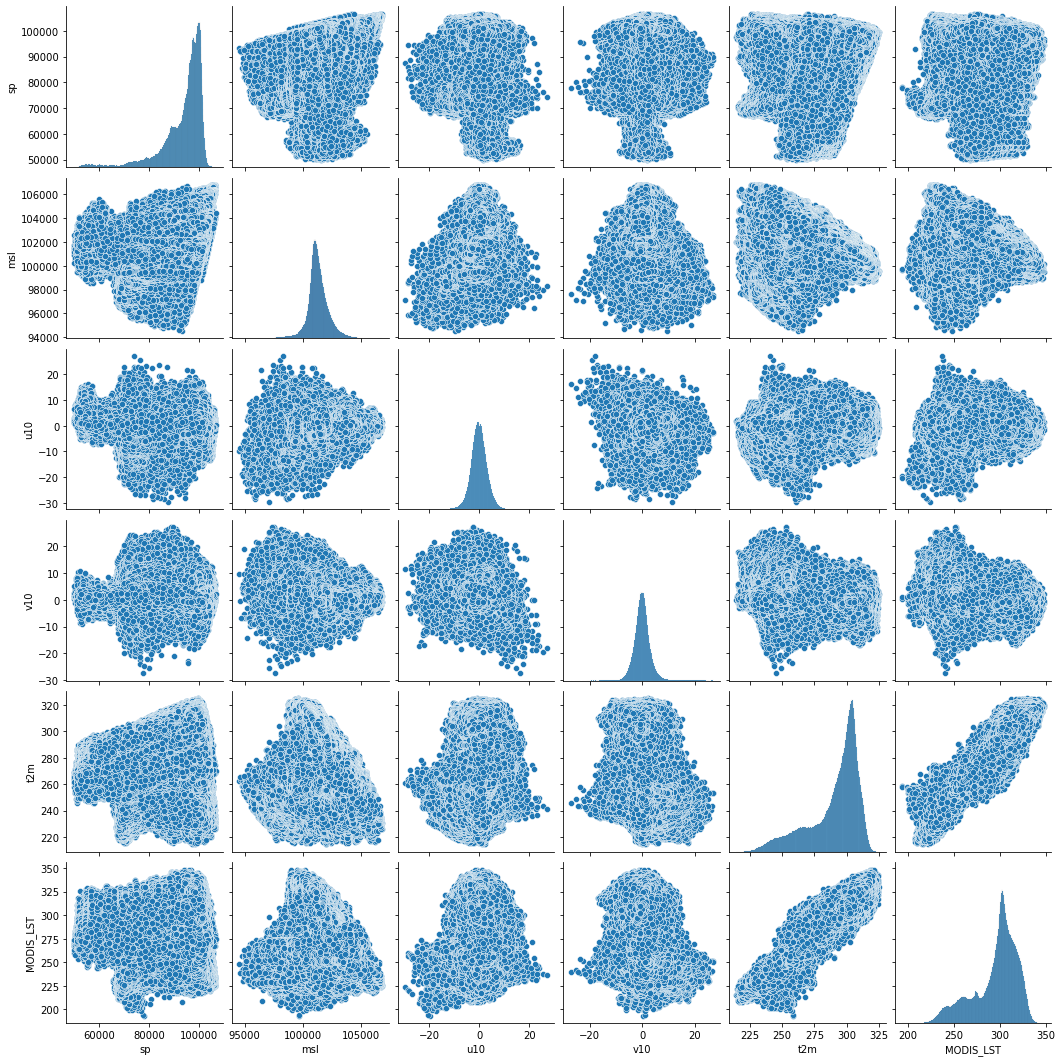

In [30]:
import seaborn as sns
training_data_lite = training_data[['sp','msl','u10', 'v10','t2m','MODIS_LST']]
sns.pairplot(training_data_lite)

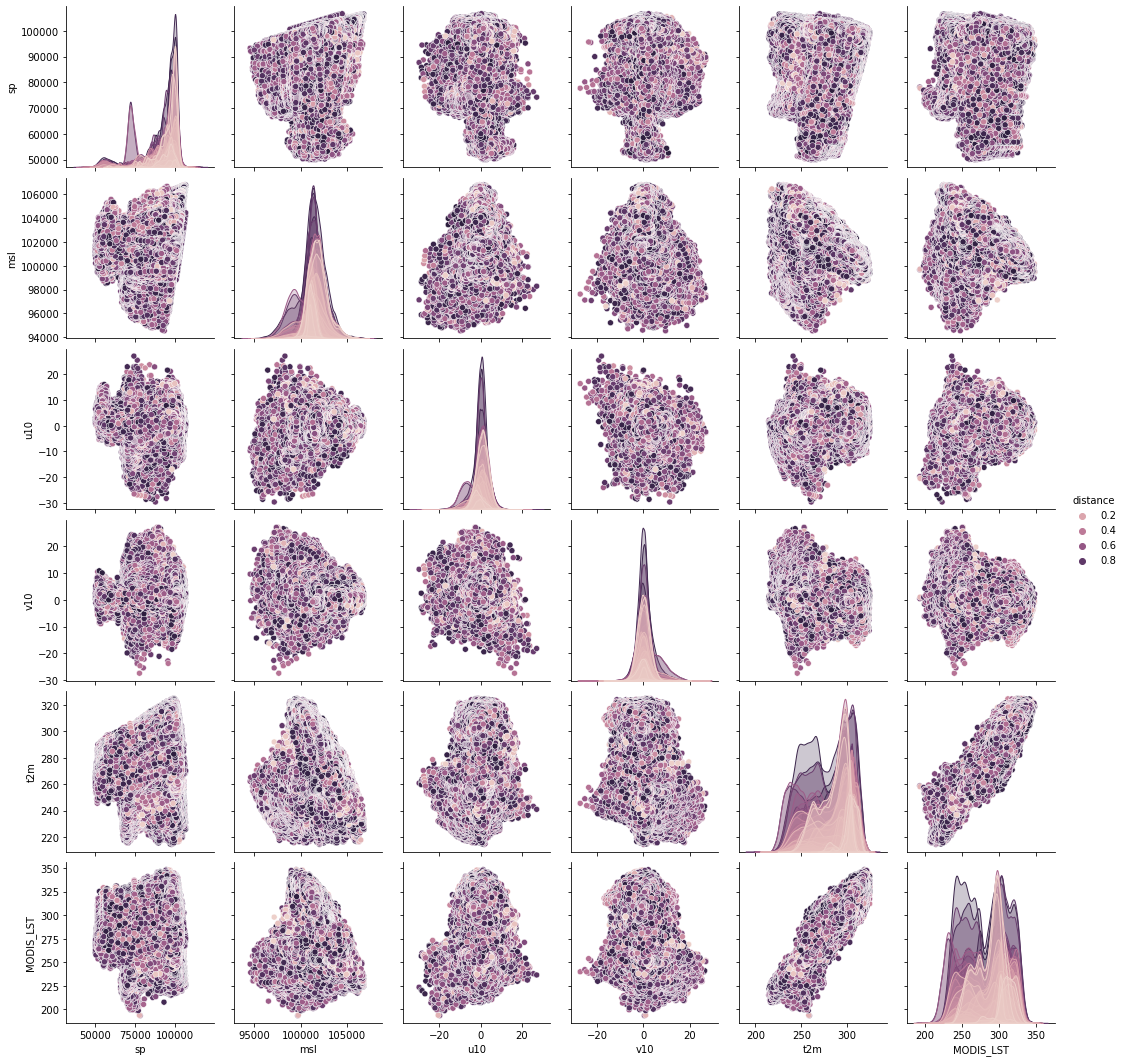

In [47]:
#Any dependence on distance?
df1 = df.query('distance <= 1.0')
df2 = df1.query('time < "2019-01-01 00:00:00"')
df3 = df2[['sp','msl','u10', 'v10','t2m','MODIS_LST','distance']]

sns.pairplot(df3,hue='distance')

Can't **see** any real corellation between features and LST, except for t2m.

What happens if we train our NN, but reduced the number of features to only 2m temperature and surface pressure?

In [49]:


reduced_features = ['t2m','sp']

x_train_lite = training_data[reduced_features]
x_test_lite = test_data[reduced_features]


#Create a normaliser layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(x_train_lite)






In [50]:
#Model
def get_lite_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(4, activation='relu',input_shape=(2,),name='layer1'),
        tf.keras.layers.Dense(3, activation='relu',name='layer2'),
        tf.keras.layers.Dense(1, name='output')
  ])

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    
    
    
    return model

In [51]:
model_lite = get_lite_model()
#model.summary()
history_lite = model_lite.fit(x_train_lite, y_train, epochs=100, batch_size=10000) #batch size is large, but smaller batch sizes plateau to roughly the same loss 

Epoch 1/100
521/521 [==============================] - 2s 2ms/step - loss: 85481.5625 - accuracy: 0.0000e+00
Epoch 2/100
521/521 [==============================] - 1s 2ms/step - loss: 67416.6172 - accuracy: 0.0000e+00
Epoch 3/100
521/521 [==============================] - 1s 2ms/step - loss: 33555.3906 - accuracy: 0.0000e+00
Epoch 4/100
521/521 [==============================] - 1s 2ms/step - loss: 10398.0586 - accuracy: 0.0000e+00
Epoch 5/100
521/521 [==============================] - 1s 2ms/step - loss: 4531.5342 - accuracy: 0.0000e+00
Epoch 6/100
521/521 [==============================] - 1s 2ms/step - loss: 2545.8103 - accuracy: 0.0000e+00
Epoch 7/100
521/521 [==============================] - 1s 2ms/step - loss: 1023.1132 - accuracy: 0.0000e+00
Epoch 8/100
521/521 [==============================] - 1s 2ms/step - loss: 289.8339 - accuracy: 0.0000e+00
Epoch 9/100
521/521 [==============================] - 1s 2ms/step - loss: 101.6825 - accuracy: 0.0000e+00
Epoch 10/100
521/521 [====

Very similar training loss after 100 epochs as in the case with more features


---

# Appendix

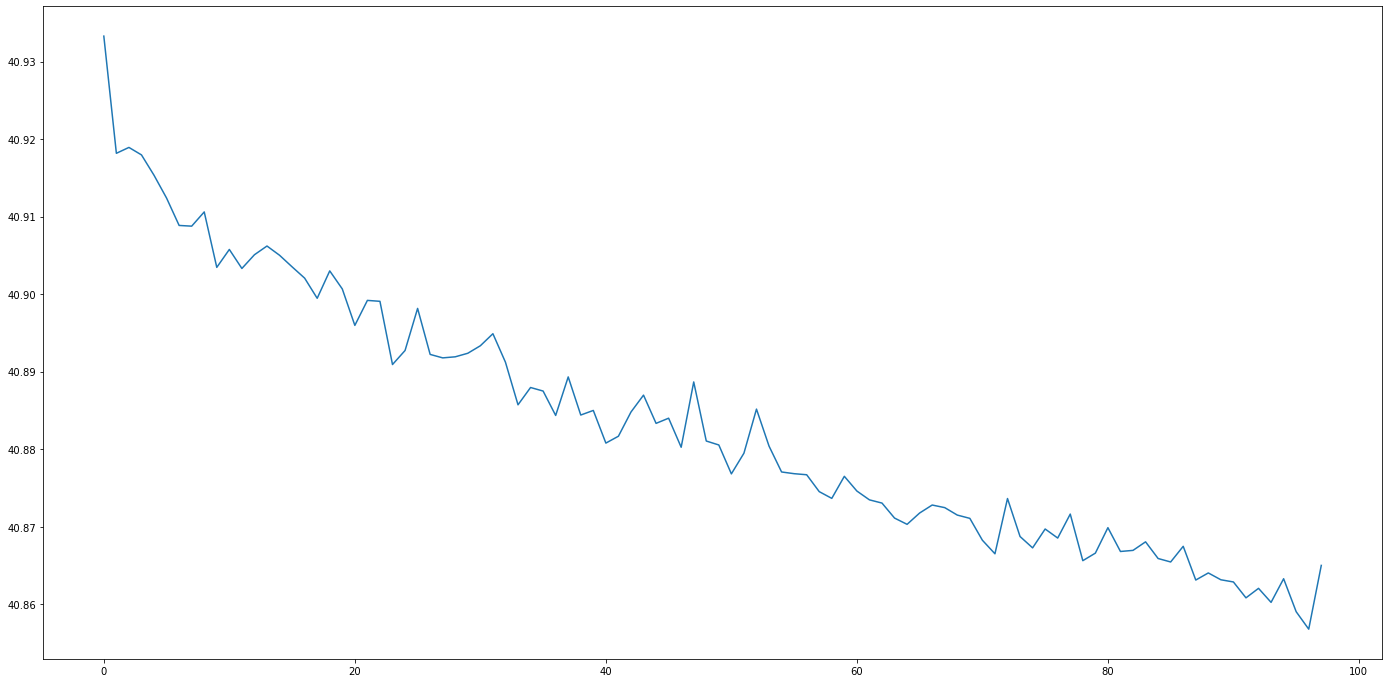

In [147]:
history.history
plt.figure(figsize=(24,12))
#plt.yscale('log')
plt.plot(history.history['loss'][2:])